In [188]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit , RooStats               

In [189]:
import sys
sys.path.append('/home/chasenberg/repos/')
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations

In [190]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random
import ROOT 
from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

Declare data directories and read files
--------------------------------------

In [527]:
#directories and files 
mc_dir = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
mc_file= 'Bd2JpsiKS_random.root'
mc_dir = os.path.join(mc_dir, mc_file)
data_dir = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/'
data_file= 'Bd2JpsiKS_final_sw.root'
data_dir = os.path.join(data_dir, data_file)

In [528]:
#Treename and cut for data
tree_data = 'Bd2JpsiKS'
cut_string_data = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
#criteria and information for read in mc
cut_string_mc = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
tree_mc = 'Bd2JpsiKS'

Load data from ROOT files
-------------------------------------------------------

In [705]:
signal_dataframe_wrongPV  = rp.read_root(mc_dir,key=tree_mc,where=cut_string_mc, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [706]:
real_dataframe_wrongPV = rp.read_root(data_dir,key=tree_data,where=cut_string_data, flatten=False)
real_dataframe_wrongPV = real_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
real_dataframe_wrongPV = real_dataframe_wrongPV.dropna()
#real_dataframe_wrongPV = pd.concat([real_dataframe_wrongPV_2015])'''

## Plot control variable "pz_pull"


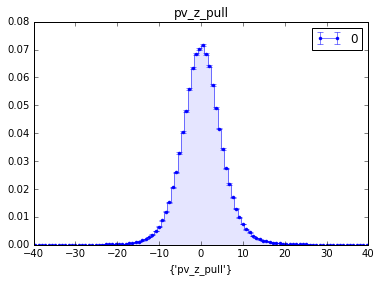

In [707]:
plot_var = ['pv_z_pull']
plot_names = plot_var

plotter = Plotter('/home/chasenberg/plots/wrong_pv/')
plotter.create_plots(signal_dataframe_wrongPV, plot_var)
plotter['pv_z_pull'].set_range(-40,40)#-5000,2000
#plotter['pv_z_pull'].set_log_y()
plotter.plot()

Declare bdt features and correlation matrix  
---------------------------------------------------------------------------------

In [985]:
bdt_features = [  
       'B0_FitPVConst_IPCHI2_flat', 
       'B0_FitPVConst_chi2_flat',
       'B0_FitPVConst_MinIPCHI2anyPV_flat',
       #'B0_FitPVConst_J_psi_1S_MinIPCHI2anyPV_flat',
       'B0_FitPVConst_J_psi_1S_IPCHI2_flat',
       #'B0_FitPVConst_KS0_IPCHI2_flat',
       #'B0_FitPVConst_KS0_MinIPCHI2anyPV_flat',
       'B0_FitDaughtersConst_KS0_IP_flat',
       'muminus_MINIPCHI2',
       'muplus_MINIPCHI2', 
       'B0_FitPVConst_PV_Z_flat',  
      # 'B0_FitPVConst_Z_flat',
       'B0_FitDaughtersConst_J_psi_1S_min_PT',
       'piplus_TRACK_Type'
]

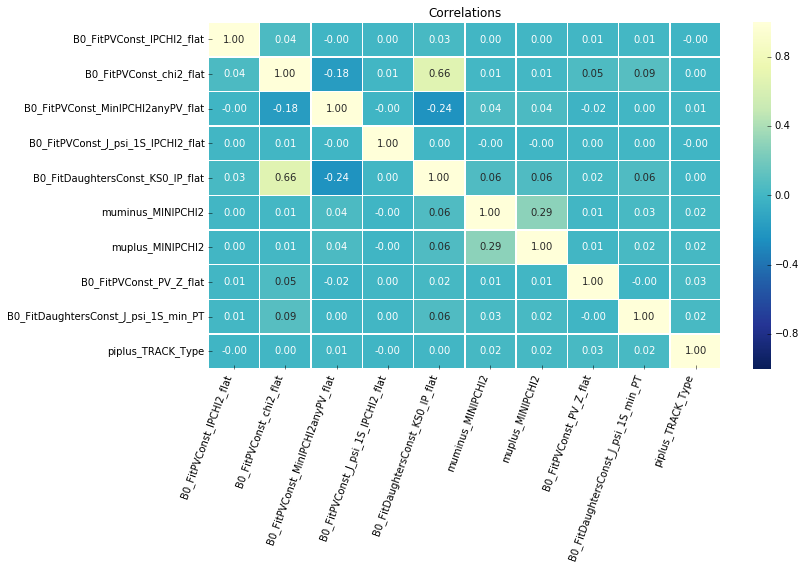

"plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')\nplt.savefig('/home/chasenberg/plots/wrong_pv/correlation_mc.png')\nplt.show()\nprint('Done!')"

In [986]:
plt.figure(figsize=(12,8))
plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))
'''plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_mc.png')
plt.show()
print('Done!')'''

Plot sWeighted BDT variables against MC
----------------------------------------------------------------------------------

In [987]:
variables = real_dataframe_wrongPV.columns.tolist().remove('signal_sw')

In [988]:
real_dataframe_wrongPV.columns

Index(['B0_TAGDECISION_OS', 'B0_TAGOMEGA_OS', 'B0_FitDaughtersConst_M_flat',
       'B0_FitDaughtersConst_chi2_flat', 'B0_FitDaughtersConst_IPCHI2_flat',
       'B0_FitDaughtersConst_J_psi_1S_IP_flat',
       'B0_FitDaughtersConst_KS0_P1_PT_flat',
       'B0_FitDaughtersConst_KS0_P0_PT_flat',
       'B0_FitDaughtersConst_KS0_decayLength_flat',
       'B0_FitDaughtersConst_KS0_IP_flat',
       'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat',
       'B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat', 'idxPV',
       'piplus_TRACK_Type', 'B0_FitPVConst_status_flat',
       'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat',
       'B0_FitDaughtersConst_J_psi_1S_P0_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat',
       'B0_FitPVConst_KS0_tau_flat', 'B0_FitPVConst_KS0_tauErr_flat',
       'B0_FitPVConst_IPCHI2_flat', 'B0_FitPVConst_MinIPCHI2anyPV_flat',
       'B0_TAU', 'B0_TAUERR', 'B0_FitDaughtersConst_status_flat',
       'piminus_MINIPCHI2', 'piplus_MINIPCHI2', 'muminus_MINIPCHI2',
       'muplu

## sWeighted data against mc

In [989]:
'''#Check bdt-variables in downstream events
mc_weight = np.ones(signal_dataframe_wrongPV.shape[0])
signal_dataframe_wrongPV['mc_weight'] = mc_weight

no_weight = np.ones(real_dataframe_wrongPV.shape[0])
real_dataframe_wrongPV['no_weight'] = no_weight
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/plots/wrong_pv/mc_agreement/')
    plotter.create_plots([real_dataframe_wrongPV,signal_dataframe_wrongPV], bdt_features, weightvars=['signal_sw','mc_weight']
    ,component_labels=['sWeighted data','Signal-MC'])
    plotter[feature].set_range(0,real_dataframe_wrongPV[feature].quantile(0.99))
    #plotter[feature].set_range(0,20)
    plotter.plot()'''

"#Check bdt-variables in downstream events\nmc_weight = np.ones(signal_dataframe_wrongPV.shape[0])\nsignal_dataframe_wrongPV['mc_weight'] = mc_weight\n\nno_weight = np.ones(real_dataframe_wrongPV.shape[0])\nreal_dataframe_wrongPV['no_weight'] = no_weight\nfor feature in bdt_features:\n    plotter = Plotter('/home/chasenberg/plots/wrong_pv/mc_agreement/')\n    plotter.create_plots([real_dataframe_wrongPV,signal_dataframe_wrongPV], bdt_features, weightvars=['signal_sw','mc_weight']\n    ,component_labels=['sWeighted data','Signal-MC'])\n    plotter[feature].set_range(0,real_dataframe_wrongPV[feature].quantile(0.99))\n    #plotter[feature].set_range(0,20)\n    plotter.plot()"

In [990]:
'''#Check bdt-variables in downstream events
mc_weight = np.ones(signal_dataframe_wrongPV.shape[0])
signal_dataframe_wrongPV['mc_weight'] = mc_weight

no_weight = np.ones(real_dataframe_wrongPV.shape[0])
real_dataframe_wrongPV['no_weight'] = no_weight
for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/plots/wrong_pv/mc_difference')
    plotter.create_plots([real_dataframe_wrongPV,signal_dataframe_wrongPV], bdt_features, weightvars=['no_weight','mc_weight']
    ,component_labels=['sWeighted data','Signal-MC'])
    plotter[feature].set_range(0,real_dataframe_wrongPV[feature].quantile(0.99))
    #plotter[feature].set_range(0,20)
    plotter.plot()'''

"#Check bdt-variables in downstream events\nmc_weight = np.ones(signal_dataframe_wrongPV.shape[0])\nsignal_dataframe_wrongPV['mc_weight'] = mc_weight\n\nno_weight = np.ones(real_dataframe_wrongPV.shape[0])\nreal_dataframe_wrongPV['no_weight'] = no_weight\nfor feature in bdt_features:\n    plotter = Plotter('/home/chasenberg/plots/wrong_pv/mc_difference')\n    plotter.create_plots([real_dataframe_wrongPV,signal_dataframe_wrongPV], bdt_features, weightvars=['no_weight','mc_weight']\n    ,component_labels=['sWeighted data','Signal-MC'])\n    plotter[feature].set_range(0,real_dataframe_wrongPV[feature].quantile(0.99))\n    #plotter[feature].set_range(0,20)\n    plotter.plot()"

Train GradienBoost classifier
====================================================================

In [991]:
correct_pvs = signal_dataframe_wrongPV.query('abs(pv_z_pull)<20')
incorrect_pvs = signal_dataframe_wrongPV.query('abs(pv_z_pull)>20')
flags = np.array([1]*len(correct_pvs)+[0]*len(incorrect_pvs))
dataframe = pd.concat([correct_pvs,incorrect_pvs])

In [992]:
correct_pvs.shape, incorrect_pvs.shape,dataframe.shape

((496785, 68), (4788, 68), (501573, 68))

In [993]:
#Apply Track Type cuts piminus_TRACK_Type

In [1106]:
train_dataframe, test_dataframe, train_flags, test_flags = train_test_split(
                                                            dataframe[bdt_features], flags, test_size=0.5, random_state=42)
classifier = GradientBoostingClassifier(max_depth=3, verbose=1,n_estimators=200,learning_rate=0.03)
classifier.fit(train_dataframe, train_flags)

      Iter       Train Loss   Remaining Time 
         1           0.1056           59.33s
         2           0.1042           59.01s
         3           0.1030           58.87s
         4           0.1020           58.46s
         5           0.1011           58.27s
         6           0.1004           57.81s
         7           0.0997           57.43s
         8           0.0991           56.99s
         9           0.0986           56.60s
        10           0.0982           56.24s
        20           0.0951           52.88s
        30           0.0935           49.69s
        40           0.0925           47.06s
        50           0.0917           48.32s
        60           0.0909           44.77s
        70           0.0903           41.03s
        80           0.0898           37.52s
        90           0.0891           35.95s
       100           0.0887           33.43s
       200           0.0864            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False)

In [1107]:
dataframe.shape

(501573, 69)

Classifier performance
-----------------------

In [1108]:
classifier.score(test_dataframe, test_flags)

0.99045803809607358

In [1109]:
importances = classifier.feature_importances_
print("Features sorted by their score:" )
importances_sorted = sorted(zip(importances, dataframe.columns), reverse=True)
for val,name in importances_sorted:
    print('{}: {:.4f}'.format(name, val))

Features sorted by their score:
B0_FitDaughtersConst_chi2_flat: 0.3366
B0_FitDaughtersConst_status_flat: 0.2440
B0_FitDaughtersConst_J_psi_1S_P1_PT_flat: 0.0879
B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat: 0.0758
B0_FitDaughtersConst_J_psi_1S_P0_PT_flat: 0.0662
B0_FitDaughtersConst_J_psi_1S_MinIPCHI2anyPV_flat: 0.0613
B0_FitDaughtersConst_M_flat: 0.0562
B0_FitDaughtersConst_IPCHI2_flat: 0.0451
B0_FitDaughtersConst_PT_flat: 0.0269
B0_FitDaughtersConst_J_psi_1S_IP_flat: 0.0000


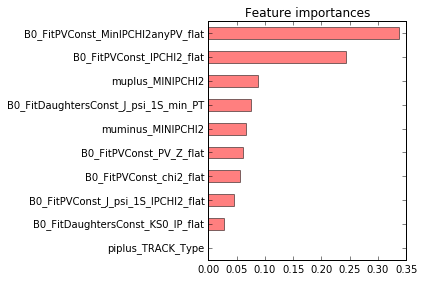

In [1110]:
#Plot feature importances 
plot_feature_importances(classifier,dataframe[bdt_features])
plt.savefig('/home/chasenberg/plots/wrong_pv/feature_importance.png', bbox_inches='tight')

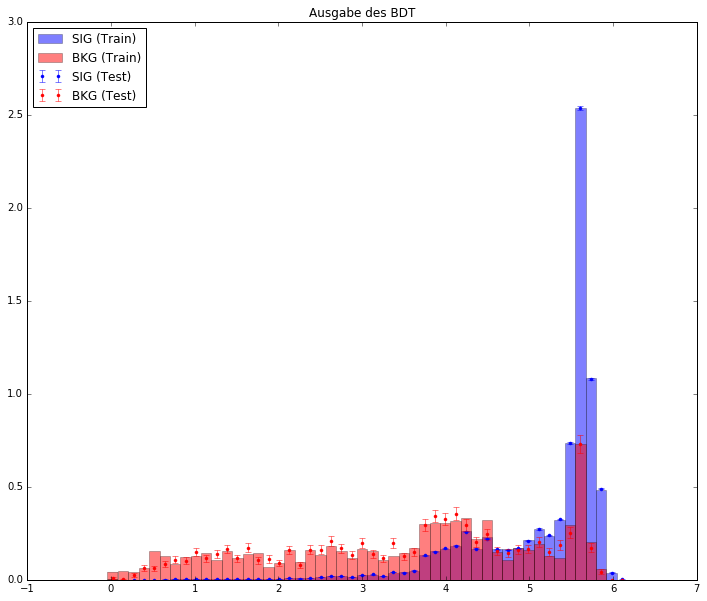

In [1111]:
plt.figure(figsize=(12,10))
plot_classifier_output(classifier, train_dataframe, train_flags, test_dataframe, test_flags, title='Ausgabe des BDT',bins=50)
plt.savefig('/home/chasenberg/plots/wrong_pv/overtraining.png')
plt.show()


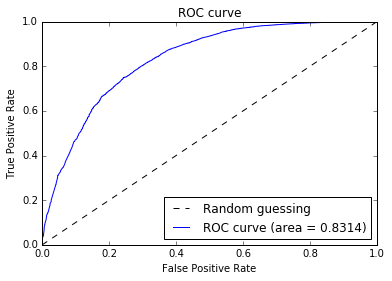

In [1112]:
plot_roc_curve(classifier, test_dataframe, test_flags)
plt.savefig('/home/chasenberg/plots/wrong_pv/roc_curve.png')




Classify unseen Data
============================================

In [1113]:
#apply classifier to data and MC
classify_unseen_data([classifier], dataframe, bdt_features, 'BDTresponse_wrongPV')

Check efficiencies of classifier cuts
-------------------------------

In [1114]:
cut = 'BDTresponse_wrongPV>4'
efficiency = dataframe.query(cut).shape[0] / dataframe.shape[0]
print('The efficiency of the cut is:')
print(efficiency,dataframe.shape[0])
#compare to best PV selection
efficiency = dataframe.query('idxPV==0').shape[0] / dataframe.shape[0]
print('The efficiency of the bestPV selection is:')
print(efficiency,dataframe.shape[0])



The efficiency of the cut is:
0.9015596932051765 501573
The efficiency of the bestPV selection is:
0.8858869994995744 501573


In [1115]:
dataframe.query(cut).to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root',key='Bd2JpsiKS')